# Making training data

Here we take the various experiments that have been run and combine them into a single training dataset

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# general libraries
import glob
import os
import pathlib
import site
import re
import sys
import warnings
from loguru import logger
# data handling libraries
import geopandas as gpd
import numpy as np
import pandas as pd
import rioxarray as rxr
import xarray as xr
from tqdm.dask import TqdmCallback as ProgressBarDask
from tqdm.notebook import tqdm as ProgressBar
# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
# machine learning libraries
import gpytorch
from sklearn import gaussian_process as gp
import torch

import cryogrid_pytools as cg
import pamir_mlpermafrost as pamir

# Loading data

In [3]:
path_output = pathlib.Path("../../pamir-CryoGrid/output/")
fnames = sorted(path_output.glob("*.zarr"))

In [7]:
# matches anything between hyphens or underscores
pattern = re.compile(r"[-_]?([a-zA-Z0-9]+)[_-]?")  

tables = []
for fname in fnames:
    logger.info(f"Processing file: {fname}")
    ds = xr.open_zarr(fname, consolidated=True)
    break
    exp = re.findall(pattern, fname.stem)[-2]
    df = pamir.data.process_permafrost.get_training_data_table(ds, experiment_name=exp)
    tables.append(df)

# table = pd.concat(tables)

2025-08-08 16:49:00.574 | INFO     | 2260048367:<module>:6 - Processing file: ../../pamir-CryoGrid/output/cluster_config-k1500-pamir_N180-exp1.zarr


In [350]:
with ProgressBarDask():
    temp_profiles = (
        ds['temperature']
        .sel(depth=slice(-0.05, -20))
        .groupby('time.season')
        .quantile([0.10, 0.5, 0.90])
        .compute()
    )

  0%|          | 0/15001 [00:00<?, ?it/s]

In [295]:
sigma_temp = temp_profiles.std(['quantile', 'season'])
sigma_temp_deep = sigma_temp.sel(depth=slice(-15, -20))

/Users/luke/Work/PAMIR/pamir-MLpermafrost/.venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


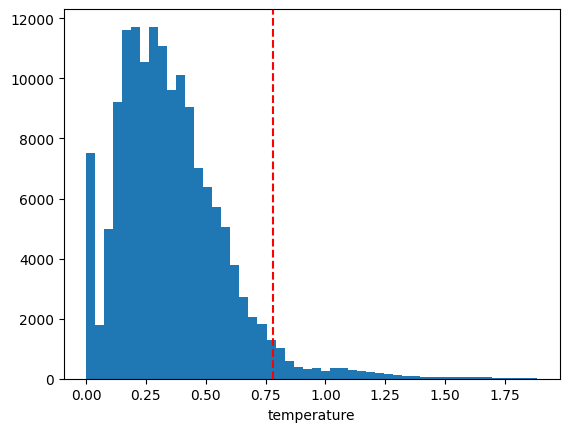

In [351]:
def get_gev_quantile(arr, q=0.99):
    """
    Fit a Generalized Extreme Value (GEV) distribution to the data and return the quantile at q.
    """
    from scipy.stats import genextreme as gev

    arr = arr[(arr != 0) & ~np.isnan(arr)]  # remove zeros and NaNs
    
    # Fit GEV (SciPy uses shape 'c' = -xi)
    c, loc, scale = gev.fit(arr)  # MLE
    x_q = gev.ppf(q, c, loc, scale)  # quantile function

    return x_q

thresh = get_gev_quantile(sigma_temp_deep.values, q=0.95)
y, x, bars = sigma_temp_deep.plot.hist(bins=50)
plt.axvline(thresh, color='red', linestyle='--', label=f'GEV 95% quantile: {thresh:.2f}')

In [352]:
deep_stable_temp = sigma_temp_deep.mean('depth') < thresh
good_profiles = temp_profiles.sel(tag=deep_stable_temp.values)

In [353]:
deep_temp_mean = good_profiles.sel(depth=slice(-19, -20)).mean(['depth', 'season'])
ref = deep_temp_mean.sel(quantile=0.5)
deep_temp_offset = deep_temp_mean - ref
profiles_corrected = good_profiles - deep_temp_offset

In [366]:
(profiles_corrected.sel(depth=-20).std(['season', 'quantile']) < 0.1).all().item()

True

(array([  12.,    0.,    0.,   25.,   29.,   18.,   24.,   36.,   24.,
          24.,   36.,   33.,   39.,   48.,   36.,   93.,   67.,   63.,
         173.,  117.,  223.,  257.,  450.,  427.,  496.,  695.,  732.,
         966., 1191., 1136.,  888.,  778.,  602.,  765.,  538.,  484.,
         453.,  331.,  298.,  269.,  384.,  599., 1297.,  360.,  420.,
         609.,  395.,  124.,   73.,   59.]),
 array([-17.46810741, -17.04975252, -16.63139763, -16.21304274,
        -15.79468785, -15.37633296, -14.95797807, -14.53962318,
        -14.12126829, -13.7029134 , -13.28455851, -12.86620362,
        -12.44784872, -12.02949383, -11.61113894, -11.19278405,
        -10.77442916, -10.35607427,  -9.93771938,  -9.51936449,
         -9.1010096 ,  -8.68265471,  -8.26429982,  -7.84594493,
         -7.42759004,  -7.00923515,  -6.59088026,  -6.17252537,
         -5.75417048,  -5.33581559,  -4.9174607 ,  -4.49910581,
         -4.08075092,  -3.66239603,  -3.24404114,  -2.82568625,
         -2.40733135,  -

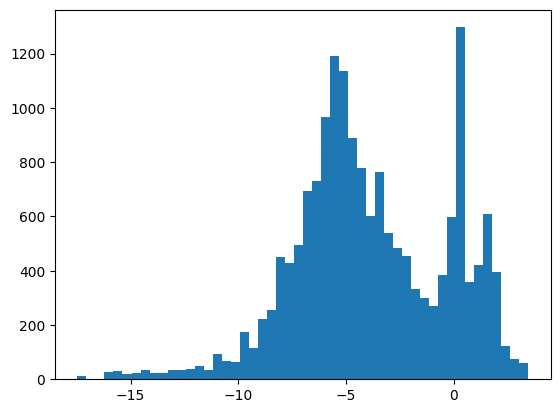

In [367]:
plt.hist(profiles_corrected.sel(depth=-20).values.ravel(), bins=50)

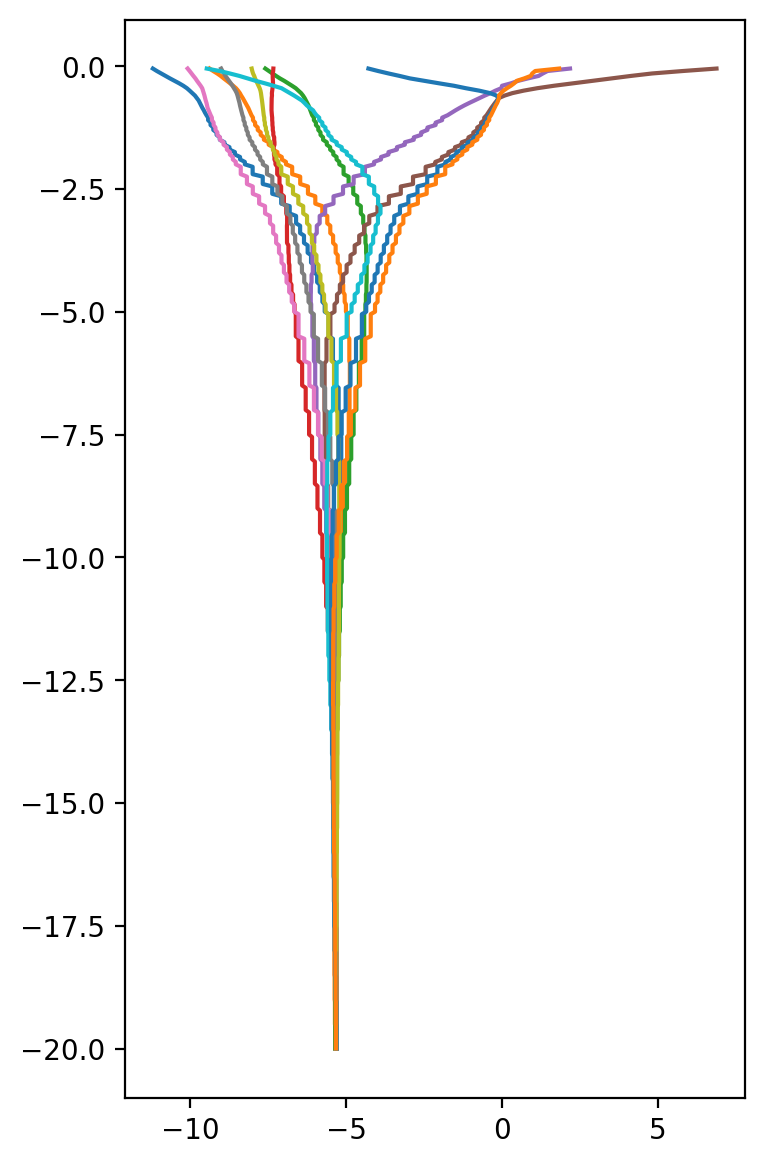

In [354]:
fig, ax = plt.subplots(figsize=(4, 7), dpi=200)
ax.plot(profiles_corrected[23].values.reshape(400, -1), profiles_corrected.depth)

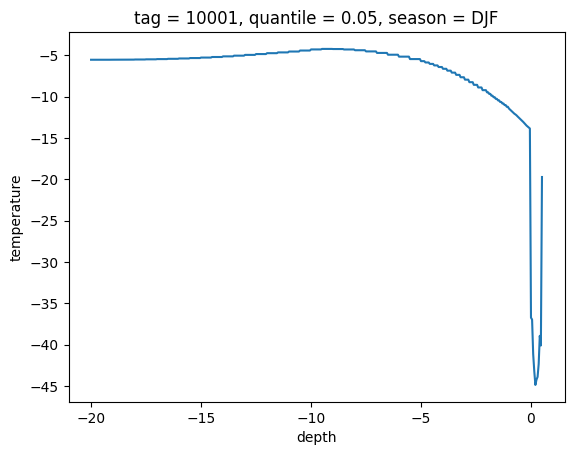

In [ ]:
temp_profiles[0, :, 0, 0]

# Collocating variables from spatial data

In [ ]:
fname_spatial = f'simplecache::s3://spi-pamir-cryogrid/processed-cluster_config/spatial_variables-710w365s750e400n-100m.zarr/'

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Open the spatial variables dataset
    ds_spatial = xr.open_zarr(fname_spatial, storage_options=pamir.data.s3_utils.fsspec_kwargs)

df_spatial = pamir.data.process_permafrost.get_collocated_spatial_data(ds_spatial, table)
df_spatial = df_spatial.dropna()

2025-07-30 11:23:16 | WARNING  - Some points in the table are not within the specified tolerance of the spatial data. Check the 'within_tolerance' column for details.


In [6]:
table['land_cover'] = df_spatial.land_cover
table['temperature'] = df_spatial.temperature
table['temperature_downscaled'] = df_spatial.temperature_downscaled
table['precipitation'] = df_spatial.precipitation
table['snow_melt_doy'] = df_spatial.snow_melt_doy

## ERA5 summer winter temperatures

In [ ]:
props = {
    'consolidated': True,
    'storage_options': {'endpoint_url': pamir.data.s3_utils.fsspec_kwargs['s3']['endpoint_url']}}

In [8]:
url_template = "s3://spi-pamir-c7-sdsc/era5_data/central_asia/central_asia-{year}.zarr/"
era5_central_asia_list = [xr.open_zarr(url_template.format(year=y), **props) for y in range(2000, 2025)]

era5_central_asia = xr.concat(era5_central_asia_list, dim='time')

era5_tajik = (
    era5_central_asia[['t2m', 'tp']]
    .sel(
        latitude=slice(40, 36.5),
        longitude=slice(70, 75),
        time=slice('2000', None))
    .rename(
        latitude='y',
        longitude='x',
        tp='precip',
        t2m='temp2m'
    )
)

In [9]:
def get_seasonal_quantiles(da, quantiles=[0.05, 0.5, 0.95], dim='time'):
    """
    Calculate seasonal quantiles for a given DataArray.
    
    Parameters:
        da (xr.DataArray): Input data array with a 'time' dimension.
        quantiles (list): List of quantiles to compute.
        dim (str): Dimension along which to compute the quantiles.
        
    Returns:
        xr.DataArray: DataArray containing the computed quantiles.
    """
    name = da.name
    
    out = (
        da.groupby(f'{dim}.season')
        .quantile(quantiles, dim=dim)
        .stack(stacked=['quantile', 'season'])
        .to_dataset(dim='stacked')
        .drop_vars(['quantile', 'season']))

    out = out.rename({
        (q, seas): f"{name}_{seas}_q{int(q*100):02d}" for q, seas in out.data_vars
    })

    return out

In [10]:
with ProgressBarDask(desc="Calculating seasonal quantiles for ERA5 data"):
    # Calculate seasonal quantiles for temperature and precipitation
    ds_era5_quantiles = (
        xr.merge(
            [get_seasonal_quantiles(era5_tajik.temp2m),
            get_seasonal_quantiles(era5_tajik.precip)])
        .interp_like(ds_spatial)
        .compute())

Calculating seasonal quantiles for ERA5 data:   0%|          | 0/3896 [00:00<?, ?it/s]

In [11]:
# ds_era5_quantiles.to_zarr('../../pamir-CryoGrid/forcing/spatial_variables-710w365s750e400n-100m.zarr/', mode='a')

In [ ]:
df_era5 = pamir.data.process_permafrost.get_collocated_spatial_data(
    ds_era5_quantiles, table).filter(regex='^temp2m_|^precip_')

2025-07-30 11:23:27 | WARNING  - Some points in the table are not within the specified tolerance of the spatial data. Check the 'within_tolerance' column for details.


In [13]:
for key in df_era5:
    table[key] = df_era5[key]

# Saving table

In [21]:
table.dropna().to_parquet('../data/training/training_data-k1500-pamir_ns180-expX.parquet')

# Creating inference data

In [13]:
fname_spatial = '../../pamir-CryoGrid/forcing/spatial_variables-710w365s750e400n-100m.zarr/'
ds_spatial = xr.open_zarr(fname_spatial).drop_vars('spatial_ref').astype('float32').load()

In [31]:
from numcodecs.zarr3 import Blosc

In [34]:
for key in ds_spatial.data_vars:
    ds_spatial[key].encoding = {'dtype': 'float32', 'compressors': Blosc()}
    ds_spatial[key].attrs = {}

for key in ds_spatial.coords:
    ds_spatial[key].encoding = {}
    ds_spatial[key].attrs = {}

In [35]:
ds_spatial.chunk({'x': 1000, 'y': 1000}).unify_chunks().to_zarr(
    '../data/inference/inference_variables-710w365s750e400n-100m.zarr', mode='w')

In [ ]:
df_inference = pamir.models.datasets.load_inference_data_from_zarr(ds_spatial.compute())

In [14]:
df_inference.to_parquet('../data/inference/inference_data-pamir_N180.parquet')